## 1. Localização de objeto utilizando diferenças quadráticas

Dada uma imagem qualquer $I_g$ e a imagem de um objeto, $I_o$ de tamanho $R\times C$, calculamos a diferença quadrática entre $I_g$ e $I_o$ em uma dada posição $(r,c)$ utilizando a fórmula

\begin{equation}
\large
d(r,c)=\sum_{s=0}^{R-1}\sum_{t=0}^{C-1}[I_g(r+s-R/2, c+t-C/2)-I_o(s,t)]^2
\end{equation}

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def quadratic_difference(img, obj):
    '''Calcula a diferença quadrática entre as imagens img e obj. É assumido que img é maior do 
       que obj. Portanto, a diferença é calculada para cada posição do centro da imagem obj ao 
       longo de img. Note que a função é facilmente modificável para processar imagens coloridas.'''
    
    num_rows, num_cols = img.shape
    num_rows_obj, num_cols_obj = obj.shape   

    half_num_rows_obj = num_rows_obj//2        # O operador // retorna a parte inteira da divisão
    half_num_cols_obj = num_cols_obj//2

    # Cria imagem com zeros ao redor da borda. Note que ao invés de adicionarmos 0, seria mais 
    # preciso calcularmos a diferença quadrática somente entre pixels contidos na imagem.
    img_padded = np.pad(img, ((half_num_rows_obj,half_num_rows_obj),
                             (half_num_cols_obj,half_num_cols_obj)), 
                             mode='reflect')
    
    img_diff = np.zeros((num_rows, num_cols))
    for row in range(num_rows):
        for col in range(num_cols):
            # patch é a região de img de mesmo tamanho que obj e centrada em (row, col)
            patch = img_padded[row:row+num_rows_obj, col:col+num_cols_obj]
            # Utilizando numpy, o comando abaixo calcula a diferença entre cada valor
            # dos arrays 2D patch e obj
            diff_region = (patch - obj)**2
            img_diff[row, col] = np.sum(diff_region)
            
    return img_diff


In [2]:
img = np.array([[5, 2, 0, 1, 4],
                [2, 4, 1, 3, 2],
                [3, 2, 3, 2, 4],
                [0, 2, 3, 4, 5],
                [2, 1, 0, 2, 3]])

img_obj = np.array([[2, 3, 2],
                    [2, 3, 4],
                    [1, 0, 2]])

img_diff = quadratic_difference(img, img_obj)
print(img_diff)

[[34. 46. 38. 18. 23.]
 [19. 33. 29. 29. 23.]
 [14. 11. 27. 32. 46.]
 [18. 15.  0. 15. 19.]
 [21. 32. 32. 46. 54.]]


In [3]:
def find_minimum(img):
    '''Encontra posição do valor mínimo de img'''
    
    ind_min = np.argmin(img)     # Índice do menor valor considerando img como um array 1D
    row_min = ind_min//img.shape[1]
    col_min = ind_min - row_min*img.shape[1]
    index = (row_min, col_min)
    smallest_val = img[index]
    
    return smallest_val, index
            
smallest_val, index = find_minimum(img_diff)
print(index)

(3, 2)


## 2. Localização de objeto utilizando correlação

A diferença quadrática entre a imagem $I_g$ e $I_o$ pode ser calculada utilizando correlação, através da fórmula:

\begin{equation}
\large
d(r,c)=I_g(r, c)^2\circ w + S_{I_o} - 2I_g(r,c)\circ I_o
\end{equation}

onde $\circ$ indica correlação e $S_{I_o}$ representa a soma dos valores de $I_o$.

In [4]:
from scipy.signal import correlate

def quadratic_difference_corr(img, obj):
    '''Calcula a diferença quadrática entre as imagens img e obj utilizando correlação-cruzada.'''
    
    w = np.ones(obj.shape)
    imgOw = correlate(img**2, w, mode='same')
    Sobj = np.sum(obj**2)
    imgOobj = correlate(img, obj, mode='same')

    img_diff = imgOw + Sobj - 2*imgOobj

    return img_diff

img_diff_corr = quadratic_difference_corr(img, img_obj)
print(img_diff_corr)

[[38. 61. 46. 34. 47.]
 [23. 33. 29. 29. 45.]
 [18. 11. 27. 32. 61.]
 [27. 15.  0. 15. 43.]
 [32. 31. 23. 22. 33.]]


## 3. Teste em imagem real

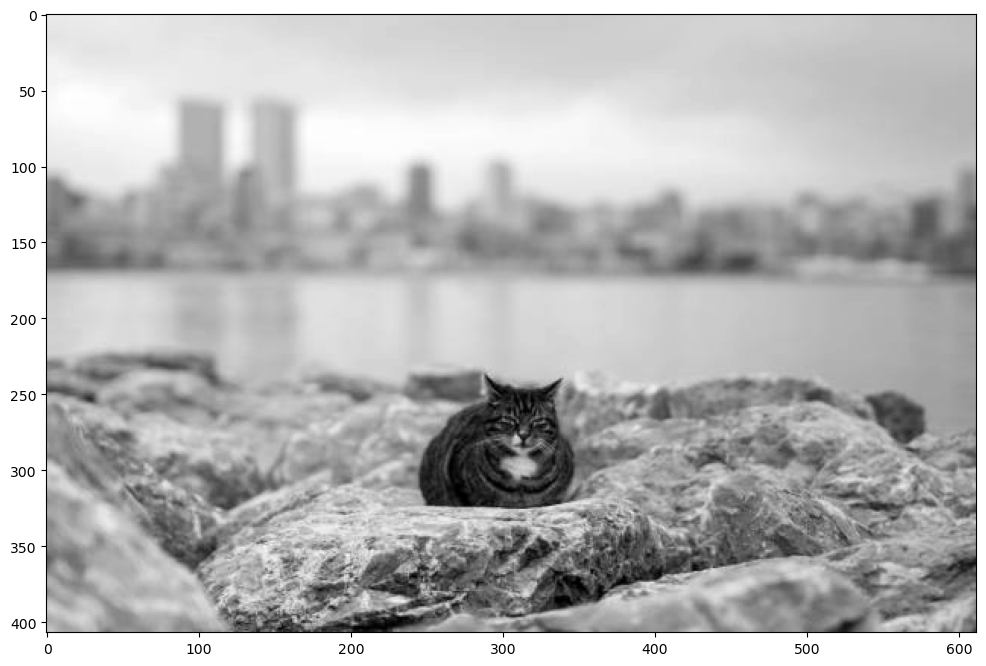

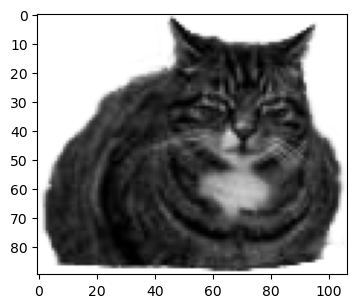

In [5]:
img_g = plt.imread('imagem_global.tiff')
img_g = img_g.astype(float)
img_o = plt.imread('gato.tiff')
img_o = img_o.astype(float)

plt.figure(figsize=[12,12])
plt.imshow(img_g, 'gray')
plt.figure(figsize=[4, 4])
plt.imshow(img_o, 'gray')

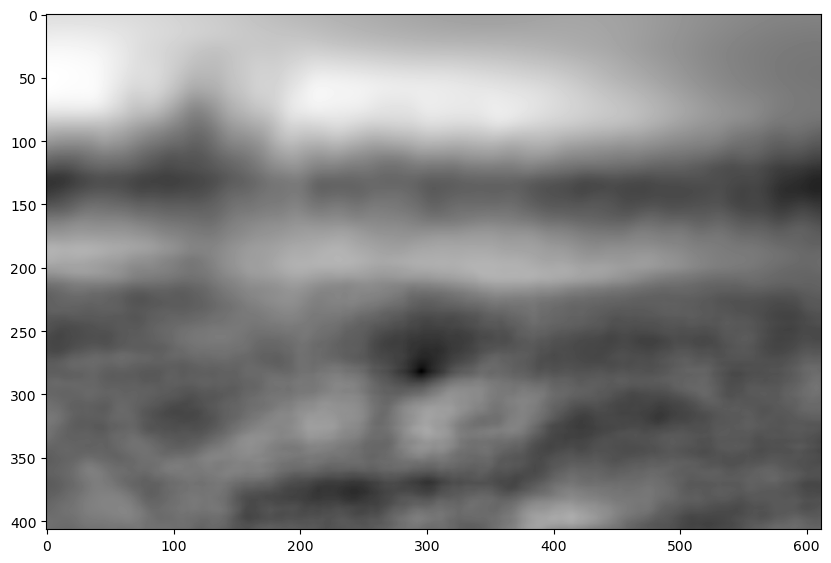

In [6]:
img_diff = quadratic_difference(img_g, img_o)
plt.figure(figsize=[10,10])
plt.imshow(img_diff, 'gray')

Observe a imagem de diferenças quadráticas acima. Vemos que o mínimo é obtido próximo à posição (280, 300). Ou seja, podemos dizer que o objeto está nessa posição. Observamos também que o valor de img_diff é maior próximo da borda. Isso ocorre porque ao comparar as duas imagens, adicionamos valores 0 ao redor da imagem maior. Como a cor de fundo do nosso template é branca, a comparação da imagem do gato com os valores 0 acaba dando um valor razoavelmente alto.

In [7]:
smallest_val, index = find_minimum(img_diff)
print('Menor diferença: {}'.format(smallest_val))
print('Posição: {}'.format(index))

Menor diferença: 40844301.0
Posição: (282, 296)


#### Cálculo da diferença quadrática utilizando correlação

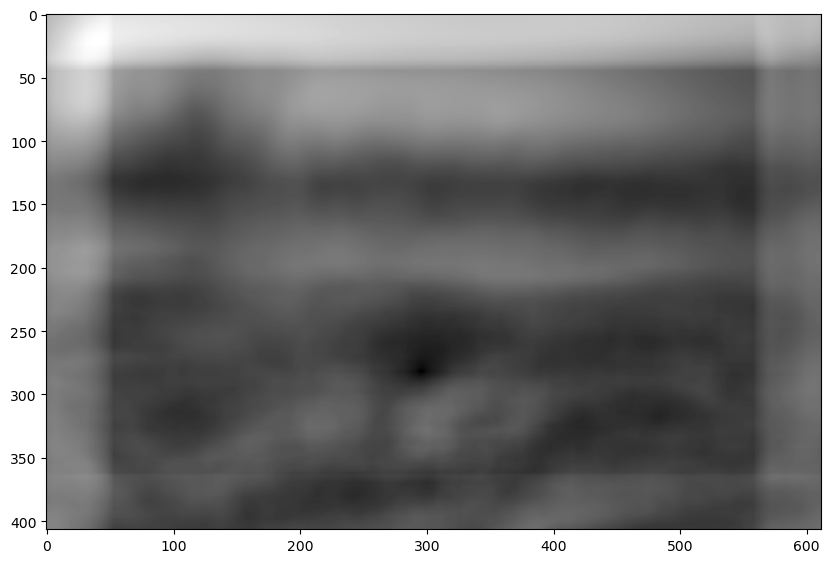

In [8]:
img_diff_corr = quadratic_difference_corr(img_g, img_o)
plt.figure(figsize=[10,10])
plt.imshow(img_diff_corr, 'gray')

Para evitar o efeito de borda, podemos considerar apenas a região do resultado que não depende do preenchimento de zeros.

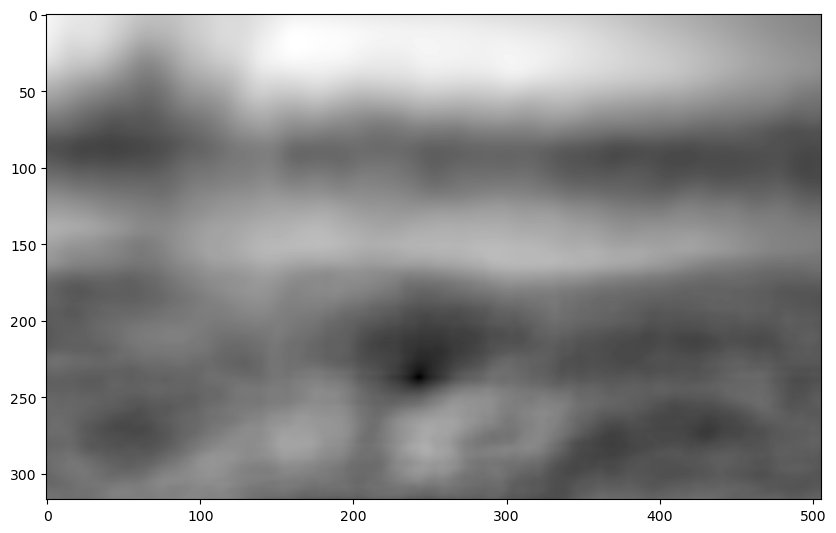

In [9]:
half_num_row_obj = img_o.shape[0]//2
half_num_col_obj = img_o.shape[1]//2
img_diff_corr_center = img_diff_corr[half_num_row_obj:-half_num_row_obj, 
                                     half_num_col_obj:-half_num_col_obj]
plt.figure(figsize=[10,10])
plt.imshow(img_diff_corr_center, 'gray')

In [14]:
from skimage.draw import rectangle_perimeter  # Biblioteca scikit-image

def draw_square(img_g, center, size):
    '''Desenha um quadrado em uma cópia do array img_g. center indica o centro do quadrado
       e size o tamanho.'''
    
    half_num_rows_obj = size[0]//2
    half_num_cols_obj = size[1]//2
    
    upper_left_p = (center[0] - size[0]//2, center[1] - size[1]//2)
    coords = rectangle_perimeter(upper_left_p, extent=size)

    img_box = img_g.copy()
    img_box[coords] = 255
    
    return img_box

img_square = draw_square(img_g, index, img_o.shape)
plt.imshow(img_square, 'gray')

ModuleNotFoundError: No module named 'skimage'

Note que o objeto na nossa imagem não corresponde de fato ao template utilizado. O nosso template possui a seguinte informação: imagem de um gato com um fundo branco. O gato encontrado na imagem na verdade tem um fundo cinza. Ou seja, apenas encontramos o gato porque ele tinha um tamanho razoavelmente grande no nosso template.

### Template matching utilizando a biblioteca opencv

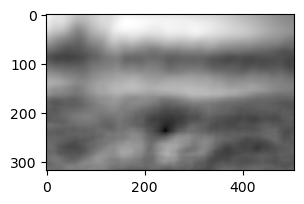

In [11]:
import cv2

res = cv2.matchTemplate(img_g.astype(np.uint8), img_o.astype(np.uint8), 
                        method=cv2.TM_SQDIFF)
plt.imshow(res, 'gray')

Um dos métodos mais utilizados para calcular a similaridade entre a imagem e o template é a correlação de Pearson. Nesse caso, valores mais altos indicam maior similaridade.

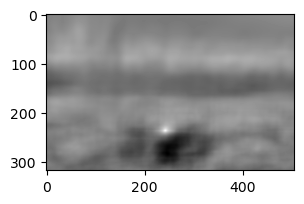

In [12]:
res = cv2.matchTemplate(img_g.astype(np.uint8), img_o.astype(np.uint8), 
                        method=cv2.TM_CCORR_NORMED)
plt.imshow(res, 'gray')